# DogFaceNet version 11: Dev version number on LFW dataset


### Imports and constants

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import pickle
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow.keras.backend as K
from triplets_processing import *
import shutil
import gc

In [2]:
PATH = 'D:/PROGRAMMATION/Dataset/lfw/lfw_center/'
PATH_SAVE = '../output/history/'
PATH_MODEL = '../output/model/'
SIZE = (151,151,3)
VALID_SPLIT = 0.1
TEST_SPLIT = 0.1

### Data pre-processing
- Load image and labels
- Training set, validation set (close-set) and testing (open-set)

In [ ]:
filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames,files)
        labels = np.append(labels,np.ones(len(files))*idx)
        idx += 1
print(len(labels))
h,w,c = SIZE
images = np.empty((len(filenames),h,w,c))
for i,f in enumerate(filenames):
    images[i] = sk.io.imread(f)

In [ ]:
# Normalization
images /= 255.0


In [3]:
# Resize all the images
filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
            sk.io.imsave(files[i],sk.transform.resize(sk.io.imread(files[i]),SIZE,anti_aliasing=True))

c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\guillaume\anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


KeyboardInterrupt: 

In [4]:
# Without imread

filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames,files)
        labels = np.append(labels,np.ones(len(files))*idx)
        idx += 1
    if len(files) == 1:
        #print(root)
        shutil.rmtree(root)
print(len(labels))
filenames

9164


array(['D:/PROGRAMMATION/Dataset/lfw/lfw_center/Aaron_Peirsol/Aaron_Peirsol_0001.jpg',
       'D:/PROGRAMMATION/Dataset/lfw/lfw_center/Aaron_Peirsol/Aaron_Peirsol_0002.jpg',
       'D:/PROGRAMMATION/Dataset/lfw/lfw_center/Aaron_Peirsol/Aaron_Peirsol_0003.jpg',
       ...,
       'D:/PROGRAMMATION/Dataset/lfw/lfw_center/Zoran_Djindjic/Zoran_Djindjic_0002.jpg',
       'D:/PROGRAMMATION/Dataset/lfw/lfw_center/Zoran_Djindjic/Zoran_Djindjic_0003.jpg',
       'D:/PROGRAMMATION/Dataset/lfw/lfw_center/Zoran_Djindjic/Zoran_Djindjic_0004.jpg'],
      dtype='<U112')

In [5]:
nbof_classes = len(np.unique(labels))
print(nbof_classes)

1680


In [64]:
# Center all the faces
for f in filenames:
    img = sk.io.imread(f)
    img_c = img[50:201,50:201,:]
    sk.io.imsave(f,img_c)

In [67]:
img_c.shape

(151, 151, 3)

### Data augmentation

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=8,
    zoom_range=0.1,
    fill_mode='nearest',
    channel_shift_range = 0.1
)

In [6]:

def apply_transform(images, datagen):
    """
    Apply a data preprocessing transformation to n images
    Args:
        -images
        -ImageDataGenerator
    Return:
        -images of the same shape of the inputs but transformed
    """
    for x in datagen.flow(images, batch_size=len(images), shuffle=False):
        return x

Open-set: test set

In [7]:
n = 3
cumul = np.empty(labels.shape)
cumul[0] = 1
crt_label = labels[0]
to_keep = []
for i in range(1,len(labels)):
    if labels[i] == labels[i-1]:
        cumul[i] = cumul[i-1] + 1
    else:
        cumul[i] = 1
        if cumul[i-1] >= n:
            to_keep += [labels[i-1]]
bool_keep = np.zeros(labels.shape, dtype=bool)
for i in range(len(to_keep)):
    bool_keep = np.logical_or(bool_keep,np.equal(to_keep[i],labels))
print("Ratio of kept classes: " + str(len(to_keep)/nbof_classes))
print("Ratio of kept images: " + str(len(labels[bool_keep])/len(labels)))
filenames_train = filenames[bool_keep]
labels_train = labels[bool_keep]

keep_test = np.logical_not(bool_keep)
filenames_test = filenames[keep_test]
labels_test = labels[keep_test]

Ratio of kept classes: 0.5357142857142857
Ratio of kept images: 0.8295504146660847


In [7]:
nbof_test = int(TEST_SPLIT*nbof_classes)

keep_test = np.less(labels,nbof_test)
keep_train = np.logical_not(keep_test)

filenames_test = filenames[keep_test]
labels_test = labels[keep_test]

filenames_train = filenames[keep_train]
labels_train = labels[keep_train]

print("Number of training data: " + str(len(filenames_train)))
print("Number of training classes: " + str(nbof_classes-nbof_test))
print("Number of testing data: " + str(len(filenames_test)))
print("Number of testing classes: " + str(nbof_test))

Number of training data: 8241
Number of training classes: 1512
Number of testing data: 923
Number of testing classes: 168


In [ ]:
nbof_test = int(TEST_SPLIT*nbof_classes)

keep_test = np.less(labels,nbof_test)
keep_train = np.logical_not(keep_test)

images_test = images[keep_test]
labels_test = labels[keep_test]

images_train = images[keep_train]
labels_train = labels[keep_train]

In [ ]:
del images
del labels
gc.collect()

In [8]:
def define_triplets_batch(filenames,labels,nbof_triplet = 21 * 3):
    
    triplet_train = []
    y_triplet = np.empty(nbof_triplet)
    classes = np.unique(labels)
    for i in range(0,nbof_triplet,3):
        # Pick a class and chose two pictures from this class
        classAP = classes[np.random.randint(len(classes))]
        keep = np.equal(labels,classAP)
        keep_classAP = filenames[keep]
        keep_classAP_idx = labels[keep]
        idx_image1 = np.random.randint(len(keep_classAP))
        idx_image2 = np.random.randint(len(keep_classAP))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(keep_classAP))

        triplet_train += [keep_classAP[idx_image1]]
        triplet_train += [keep_classAP[idx_image2]]
        y_triplet[i] = keep_classAP_idx[idx_image1]
        y_triplet[i+1] = keep_classAP_idx[idx_image2]
        # Pick a class for the negative picture
        classN = classes[np.random.randint(len(classes))]
        while classN==classAP:
            classN = classes[np.random.randint(len(classes))]
        keep = np.equal(labels,classN)
        keep_classN = filenames[keep]
        keep_classN_idx = labels[keep]
        idx_image3 = np.random.randint(len(keep_classN))
        triplet_train += [keep_classN[idx_image3]]
        y_triplet[i+2] = keep_classN_idx[idx_image3]
        
    return triplet_train, y_triplet

In [54]:
def define_hard_triplets_batch(filenames,labels,predict,nbof_triplet=21*3, use_neg=True):
    """
    Generates hard triplet for offline selection. It will consider the whole dataset.
    
    Args:
        -images: images from which the triplets will be created
        -labels: labels of the images
        -predict: predicted embeddings for the images by the trained model
        -alpha: threshold of the triplet loss
    Returns:
        -triplet
        -y_triplet: labels of the triplets
    """
    # Check if we have the right number of triplets
    assert nbof_triplet%3 == 0
    
    _,idx_classes = np.unique(labels,return_index=True)
    classes = labels[np.sort(idx_classes)]
    
    triplets = []
    y_triplets = np.empty(nbof_triplet)
    
    idx_triplets = 0
    idx_images = 0
    
    for i in range(0,nbof_triplet,3):
        # Chooses the first class randomly
        keep = np.equal(labels,classes[np.random.randint(len(classes))])
        keep_filenames = filenames[keep]
        keep_labels = labels[keep]
        
        # Chooses the first image among this class randomly
        idx_image1 = np.random.randint(len(keep_labels))
        
        
        # Computes the distance between the chosen image and the rest of the class
        dist_class = np.sum(np.square(predict[keep]-predict[keep][idx_image1]),axis=-1)
        
        idx_image2 = np.argmax(dist_class)
        
        triplets += [keep_filenames[idx_image1]]
        y_triplets[i] = keep_labels[idx_image1]
        triplets += [keep_filenames[idx_image2]]
        y_triplets[i+1] = keep_labels[idx_image2]
        
        
        # Computes the distance between the chosen image and the rest of the other classes
        not_keep = np.logical_not(keep)
        
        if use_neg:
            dist_other = np.sum(np.square(predict[not_keep]-predict[keep][idx_image1]),axis=-1)
            idx_image3 = np.argmin(dist_other) 
        else:
            idx_image3 = np.random.randint(len(filenames[not_keep]))
            
        triplets += [filenames[not_keep][idx_image3]]
        y_triplets[i+2] = labels[not_keep][idx_image3]

    return triplets, y_triplets

In [10]:
def load_images(filenames):
    h,w,c = SIZE
    #print(filenames)
    images = np.empty((len(filenames),h,w,c))
    for i,f in enumerate(filenames):
        #print(f)
        images[i] = sk.io.imread(f)/255.0
    return images

In [11]:
def image_generator(filenames, labels, batch_size=63, use_aug=True, datagen=datagen):
    while True:
        f_triplet, y_triplet = define_triplets_batch(filenames, labels, batch_size)
        i_triplet = load_images(f_triplet)
        if use_aug:
            i_triplet = apply_transform(i_triplet, datagen)
        yield (i_triplet, y_triplet)

In [51]:
def hard_image_generator(filenames, labels, predict, batch_size=63, use_neg=True, use_aug=True, datagen=datagen):
    while True:
        f_triplet, y_triplet = define_hard_triplets_batch(filenames, labels, predict, batch_size, use_neg=use_neg)
        i_triplet = load_images(f_triplet)
        if use_aug:
            i_triplet = apply_transform(i_triplet, datagen)
        yield (i_triplet, y_triplet)

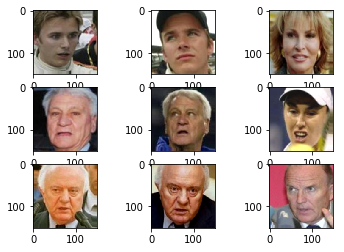

In [13]:
# Test normal triplets
for a,y in image_generator(filenames_train,labels_train,9):
    for i in range(3):
        for j in range(3):
            plt.subplot(3,3,3*i+j+1)
            plt.imshow(a[i*3+j])
    break

In [ ]:
fs = filenames_train[np.equal(labels_train,745)]
print(fs)
ise = load_images(fs)
for i in range(len(ise)):
    plt.subplot(len(ise),5,i+1)
    plt.imshow(ise[i])

[ 740.  740.  833.  805.  805.  844. 1067. 1067.  779.  613.  613.  819.
  849.  849. 1053. 1315. 1315.  630. 1001. 1001.  637. 1617. 1617. 1311.
 1269. 1269. 1216.  725.  725.  817.]


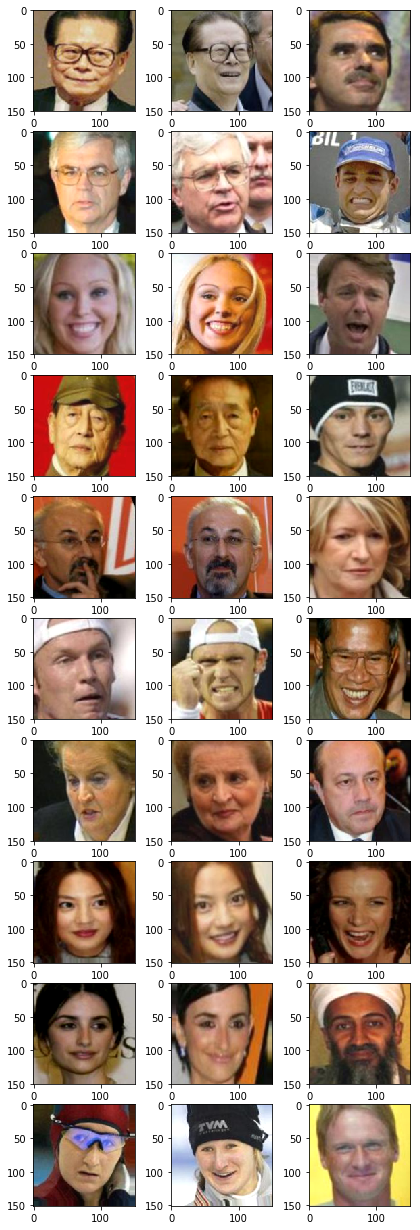

In [52]:
# Test hard triplets
batch_predict = 32

#predict_train = np.random.random((len(labels_train),1))
predict_train = model.predict_generator(predict_generator(filenames_train, batch_predict),
                                  steps=np.ceil(len(filenames_train)/batch_predict))
disp = 10
plt.figure(figsize=(7,disp*2.2))
for a,y in hard_image_generator(filenames_train,labels_train, predict_train, disp*3, use_neg=False):
    for i in range(10):
        for j in range(3):
            plt.subplot(10,3,3*i+j+1)
            plt.imshow(a[i*3+j])
    print(y)
    break

In [15]:
def predict_generator(filenames, batch_size=32):
    for i in range(0,len(filenames),batch_size):
        images_batch = load_images(filenames[i:i+batch_size])
        yield images_batch

In [37]:
# Test predict_generator
batch_predict = 32
predict_train = model.predict_generator(predict_generator(filenames_train, batch_predict),
                                  steps=np.ceil(len(filenames_train)/batch_predict))
print(len(predict_train))

8241


Triplet test definition

In [ ]:
h,w,c = SIZE
images_test = np.empty((len(filenames_test),h,w,c))
for i,f in enumerate(filenames_test):
    images_test[i] = sk.io.imread(f)

In [ ]:
#triplet_train, y_triplet_train = define_triplets(images_train,labels_train)
triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)

### Loss definition

In [16]:
alpha = 0.3
def triplet(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)

    return K.sum(tf.nn.relu(ap - an + alpha))

### Metric definition

In [17]:
def triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)
    
    return K.less(ap+alpha,an)

### Model definition

In [ ]:
# inception net small

emb_size = 64

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=SIZE)

x = Conv2D(64, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

for layer in [16,32,64,128,512]:

    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    r = BatchNormalization()(x)
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    r = Add()([r,x])
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    x = Add()([r,x])
    x = Dropout(0.25)(x)
    

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [44]:
# dogfacenet_v25: Resnet like
emb_size = 64

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=SIZE)

x = Conv2D(64, (7, 7), strides=(2,2), use_bias=False, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((3,3),strides=(2,2))(x)

for layer in [128,256]:

    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, padding='same')(x)
    r = BatchNormalization()(x)
    r = Activation('relu')(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, padding='same')(r)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    r = Add()([r,x])
    
    x = Conv2D(layer, (3, 3), use_bias=False, padding='same')(r)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Add()([r,x])

    

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.6)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 151, 151, 3)  0                                            
__________________________________________________________________________________________________
conv2d_255 (Conv2D)             (None, 76, 76, 64)   9408        input_27[0][0]                   
__________________________________________________________________________________________________
batch_normalization_255 (BatchN (None, 76, 76, 64)   256         conv2d_255[0][0]                 
__________________________________________________________________________________________________
activation_255 (Activation)     (None, 76, 76, 64)   0           batch_normalization_255[0][0]    
__________________________________________________________________________________________________
max_poolin

In [ ]:
# dogfacenet_v11: VGG like
emb_size = 16

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(104, 104, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_size))
model.add(Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1)))

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [56]:
# dogfacenet_v12: Resnet like
emb_size = 64

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=SIZE)

x = Conv2D(16, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

for layer in [16,32,64,128,512]:

    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    r = BatchNormalization()(x)
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    r = Add()([r,x])
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    x = Add()([r,x])
    x = Dropout(0.25)(x)
    

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 151, 151, 3)  0                                            
__________________________________________________________________________________________________
conv2d_262 (Conv2D)             (None, 151, 151, 16) 2352        input_28[0][0]                   
__________________________________________________________________________________________________
batch_normalization_262 (BatchN (None, 151, 151, 16) 64          conv2d_262[0][0]                 
__________________________________________________________________________________________________
conv2d_263 (Conv2D)             (None, 76, 76, 16)   2304        batch_normalization_262[0][0]    
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
batch_normalization_272 (BatchN (None, 10, 10, 128)  512         conv2d_272[0][0]                 
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 10, 10, 128)  0           batch_normalization_272[0][0]    
__________________________________________________________________________________________________
conv2d_273 (Conv2D)             (None, 10, 10, 128)  147456      dropout_28[0][0]                 
__________________________________________________________________________________________________
batch_normalization_273 (BatchN (None, 10, 10, 128)  512         conv2d_273[0][0]                 
__________________________________________________________________________________________________
add_162 (Add)                   (None, 10, 10, 128)  0           dropout_28[0][0]                 
          

In [57]:
# dogfacenet_v12: Resnet like
emb_size = 64

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=SIZE)

x = Conv2D(16, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

for layer in [16,32,64,128,512]:

    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    r = BatchNormalization()(x)
#     r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    r = Add()([r,x])
#     r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    x = Add()([r,x])
#     x = Dropout(0.25)(x)
    

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 151, 151, 3)  0                                            
__________________________________________________________________________________________________
conv2d_278 (Conv2D)             (None, 151, 151, 16) 2352        input_29[0][0]                   
__________________________________________________________________________________________________
batch_normalization_278 (BatchN (None, 151, 151, 16) 64          conv2d_278[0][0]                 
__________________________________________________________________________________________________
conv2d_279 (Conv2D)             (None, 76, 76, 16)   2304        batch_normalization_278[0][0]    
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
batch_normalization_291 (BatchN (None, 5, 5, 512)    2048        conv2d_291[0][0]                 
__________________________________________________________________________________________________
conv2d_292 (Conv2D)             (None, 5, 5, 512)    2359296     batch_normalization_291[0][0]    
__________________________________________________________________________________________________
batch_normalization_292 (BatchN (None, 5, 5, 512)    2048        conv2d_292[0][0]                 
__________________________________________________________________________________________________
add_174 (Add)                   (None, 5, 5, 512)    0           batch_normalization_291[0][0]    
                                                                 batch_normalization_292[0][0]    
__________________________________________________________________________________________________
conv2d_293

In [14]:
model = tf.keras.models.load_model(PATH_MODEL + '2019.04.12.dogfacenet_v12.lfw.13.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [58]:
histories = []

In [17]:
histories += [model.fit_generator(
    hard_image_generator(filenames_train,labels_train,predict_train,3*40),
    steps_per_epoch=500,
    epochs=1,
    validation_data=image_generator(filenames_test,labels_test,3*40,False),
    validation_steps=30
)]

NameError: name 'predict_train' is not defined

In [59]:
# With hard triplet generation
for i in range(20):
    predict_train = model.predict_generator(predict_generator(filenames_train, 32),
                                  steps=np.ceil(len(filenames_train)/32))
    histories += [model.fit_generator(
        hard_image_generator(filenames_train,labels_train,predict_train,3*10,use_neg=False),
        steps_per_epoch=500,
        epochs=4,
        validation_data=image_generator(filenames_test,labels_test,3*10,False),
        validation_steps=30
    )]
    model.save(PATH_MODEL + '2019.04.15.dogfacenet_v12.lfw.'+str(i)+'.h5')

Epoch 1/4


170/500 [=========>....................] - ETA: 54:59 - loss: 2.0988 - triplet_acc: 0.50 - ETA: 28:13 - loss: 2.7460 - triplet_acc: 0.45 - ETA: 19:17 - loss: 4.3282 - triplet_acc: 0.40 - ETA: 14:50 - loss: 4.7978 - triplet_acc: 0.40 - ETA: 12:09 - loss: 4.3276 - triplet_acc: 0.46 - ETA: 10:22 - loss: 3.8977 - triplet_acc: 0.50 - ETA: 9:05 - loss: 4.8466 - triplet_acc: 0.4571 - ETA: 8:07 - loss: 4.8645 - triplet_acc: 0.437 - ETA: 7:23 - loss: 4.9908 - triplet_acc: 0.444 - ETA: 6:47 - loss: 5.2060 - triplet_acc: 0.440 - ETA: 6:17 - loss: 5.0626 - triplet_acc: 0.436 - ETA: 5:53 - loss: 4.7791 - triplet_acc: 0.458 - ETA: 5:32 - loss: 4.6046 - triplet_acc: 0.469 - ETA: 5:14 - loss: 4.5045 - triplet_acc: 0.478 - ETA: 4:59 - loss: 4.4132 - triplet_acc: 0.493 - ETA: 4:45 - loss: 4.3068 - triplet_acc: 0.506 - ETA: 4:33 - loss: 4.5622 - triplet_acc: 0.494 - ETA: 4:22 - loss: 4.7349 - triplet_acc: 0.483 - ETA: 4:13 - loss: 4.7006 - triplet_acc: 0.484 - ETA: 4:04 - loss: 4.7399 - triplet_acc: 0.48

229/500 [============>.................] - ETA: 1:45 - loss: 4.2132 - triplet_acc: 0.440 - ETA: 1:44 - loss: 4.2106 - triplet_acc: 0.441 - ETA: 1:44 - loss: 4.1981 - triplet_acc: 0.441 - ETA: 1:44 - loss: 4.1963 - triplet_acc: 0.441 - ETA: 1:43 - loss: 4.1972 - triplet_acc: 0.440 - ETA: 1:43 - loss: 4.1912 - triplet_acc: 0.440 - ETA: 1:43 - loss: 4.1823 - triplet_acc: 0.441 - ETA: 1:42 - loss: 4.1811 - triplet_acc: 0.440 - ETA: 1:42 - loss: 4.1762 - triplet_acc: 0.441 - ETA: 1:42 - loss: 4.1711 - triplet_acc: 0.441 - ETA: 1:41 - loss: 4.1639 - triplet_acc: 0.441 - ETA: 1:41 - loss: 4.1663 - triplet_acc: 0.440 - ETA: 1:41 - loss: 4.1712 - triplet_acc: 0.439 - ETA: 1:40 - loss: 4.1791 - triplet_acc: 0.439 - ETA: 1:40 - loss: 4.1813 - triplet_acc: 0.438 - ETA: 1:39 - loss: 4.1830 - triplet_acc: 0.438 - ETA: 1:39 - loss: 4.2006 - triplet_acc: 0.437 - ETA: 1:39 - loss: 4.1961 - triplet_acc: 0.436 - ETA: 1:38 - loss: 4.1766 - triplet_acc: 0.439 - ETA: 1:38 - loss: 4.1644 - triplet_acc: 0.439

KeyboardInterrupt: 

In [23]:
model.save(PATH_MODEL + '2019.04.12.dogfacenet_v12.lfw.'+str(1)+'.h5')

In [33]:
# Without hard triplet generation
#histories = []
for i in range(30):
    print("Epoch: " + str(i))
    histories += [model.fit_generator(
        image_generator(filenames_train,labels_train,3*10),
        steps_per_epoch=300,
        epochs=1,
        validation_data=image_generator(filenames_test,labels_test,3*10,False),
        validation_steps=30
    )]

Epoch: 0
Epoch 1/1
177/300 [================>.............] - ETA: 3:27 - loss: 0.5099 - triplet_acc: 0.700 - ETA: 2:06 - loss: 1.8670 - triplet_acc: 0.600 - ETA: 1:38 - loss: 1.4862 - triplet_acc: 0.566 - ETA: 1:24 - loss: 1.3439 - triplet_acc: 0.600 - ETA: 1:16 - loss: 1.4548 - triplet_acc: 0.600 - ETA: 1:10 - loss: 1.4931 - triplet_acc: 0.583 - ETA: 1:07 - loss: 1.4119 - triplet_acc: 0.571 - ETA: 1:03 - loss: 1.4924 - triplet_acc: 0.575 - ETA: 1:01 - loss: 1.4419 - triplet_acc: 0.600 - ETA: 59s - loss: 1.4750 - triplet_acc: 0.590 - ETA: 57s - loss: 1.3884 - triplet_acc: 0.60 - ETA: 56s - loss: 1.4150 - triplet_acc: 0.59 - ETA: 56s - loss: 1.4084 - triplet_acc: 0.59 - ETA: 55s - loss: 1.5513 - triplet_acc: 0.57 - ETA: 55s - loss: 1.5303 - triplet_acc: 0.56 - ETA: 54s - loss: 1.5929 - triplet_acc: 0.56 - ETA: 54s - loss: 1.6190 - triplet_acc: 0.54 - ETA: 54s - loss: 1.6653 - triplet_acc: 0.53 - ETA: 54s - loss: 1.6851 - triplet_acc: 0.52 - ETA: 53s - loss: 1.7069 - triplet_acc: 0.51 -

177/300 [================>.............] - ETA: 1:37 - loss: 1.0176 - triplet_acc: 0.700 - ETA: 1:15 - loss: 1.5428 - triplet_acc: 0.600 - ETA: 1:09 - loss: 1.2410 - triplet_acc: 0.600 - ETA: 1:05 - loss: 1.2870 - triplet_acc: 0.600 - ETA: 1:03 - loss: 1.3168 - triplet_acc: 0.600 - ETA: 1:00 - loss: 1.1261 - triplet_acc: 0.633 - ETA: 59s - loss: 1.0956 - triplet_acc: 0.642 - ETA: 58s - loss: 1.0523 - triplet_acc: 0.63 - ETA: 57s - loss: 0.9497 - triplet_acc: 0.65 - ETA: 56s - loss: 1.0157 - triplet_acc: 0.65 - ETA: 56s - loss: 1.0746 - triplet_acc: 0.63 - ETA: 55s - loss: 1.1560 - triplet_acc: 0.61 - ETA: 55s - loss: 1.1623 - triplet_acc: 0.60 - ETA: 54s - loss: 1.1690 - triplet_acc: 0.60 - ETA: 54s - loss: 1.2257 - triplet_acc: 0.60 - ETA: 53s - loss: 1.2018 - triplet_acc: 0.60 - ETA: 53s - loss: 1.1862 - triplet_acc: 0.61 - ETA: 53s - loss: 1.1945 - triplet_acc: 0.61 - ETA: 53s - loss: 1.2254 - triplet_acc: 0.60 - ETA: 52s - loss: 1.2530 - triplet_acc: 0.59 - ETA: 52s - loss: 1.2731 

300/300 [==============================] - ETA: 22s - loss: 1.1777 - triplet_acc: 0.63 - ETA: 22s - loss: 1.1782 - triplet_acc: 0.63 - ETA: 22s - loss: 1.1771 - triplet_acc: 0.63 - ETA: 22s - loss: 1.1741 - triplet_acc: 0.63 - ETA: 22s - loss: 1.1764 - triplet_acc: 0.63 - ETA: 21s - loss: 1.1738 - triplet_acc: 0.63 - ETA: 21s - loss: 1.1789 - triplet_acc: 0.62 - ETA: 21s - loss: 1.1760 - triplet_acc: 0.62 - ETA: 21s - loss: 1.1773 - triplet_acc: 0.62 - ETA: 21s - loss: 1.1756 - triplet_acc: 0.62 - ETA: 20s - loss: 1.1736 - triplet_acc: 0.62 - ETA: 20s - loss: 1.1811 - triplet_acc: 0.62 - ETA: 20s - loss: 1.1818 - triplet_acc: 0.62 - ETA: 20s - loss: 1.1836 - triplet_acc: 0.62 - ETA: 20s - loss: 1.1917 - triplet_acc: 0.62 - ETA: 19s - loss: 1.1887 - triplet_acc: 0.62 - ETA: 19s - loss: 1.1931 - triplet_acc: 0.62 - ETA: 19s - loss: 1.1977 - triplet_acc: 0.62 - ETA: 19s - loss: 1.1971 - triplet_acc: 0.62 - ETA: 19s - loss: 1.1947 - triplet_acc: 0.62 - ETA: 19s - loss: 1.1970 - triplet_acc

177/300 [================>.............] - ETA: 1:37 - loss: 0.9590 - triplet_acc: 0.500 - ETA: 1:17 - loss: 0.9755 - triplet_acc: 0.550 - ETA: 1:12 - loss: 1.0259 - triplet_acc: 0.533 - ETA: 1:07 - loss: 0.8990 - triplet_acc: 0.575 - ETA: 1:04 - loss: 0.8441 - triplet_acc: 0.600 - ETA: 1:02 - loss: 0.8801 - triplet_acc: 0.583 - ETA: 1:01 - loss: 0.9042 - triplet_acc: 0.614 - ETA: 1:00 - loss: 0.9323 - triplet_acc: 0.600 - ETA: 58s - loss: 0.8847 - triplet_acc: 0.611 - ETA: 58s - loss: 1.0094 - triplet_acc: 0.60 - ETA: 57s - loss: 1.0029 - triplet_acc: 0.60 - ETA: 57s - loss: 1.1826 - triplet_acc: 0.58 - ETA: 56s - loss: 1.2218 - triplet_acc: 0.56 - ETA: 55s - loss: 1.1861 - triplet_acc: 0.57 - ETA: 55s - loss: 1.2082 - triplet_acc: 0.58 - ETA: 54s - loss: 1.1950 - triplet_acc: 0.58 - ETA: 54s - loss: 1.2469 - triplet_acc: 0.58 - ETA: 53s - loss: 1.2098 - triplet_acc: 0.59 - ETA: 53s - loss: 1.1886 - triplet_acc: 0.60 - ETA: 53s - loss: 1.1532 - triplet_acc: 0.61 - ETA: 52s - loss: 1.1

300/300 [==============================] - ETA: 22s - loss: 1.2064 - triplet_acc: 0.62 - ETA: 22s - loss: 1.2002 - triplet_acc: 0.62 - ETA: 22s - loss: 1.2018 - triplet_acc: 0.62 - ETA: 21s - loss: 1.2011 - triplet_acc: 0.62 - ETA: 21s - loss: 1.2022 - triplet_acc: 0.62 - ETA: 21s - loss: 1.2003 - triplet_acc: 0.62 - ETA: 21s - loss: 1.2010 - triplet_acc: 0.62 - ETA: 21s - loss: 1.1983 - triplet_acc: 0.62 - ETA: 21s - loss: 1.2010 - triplet_acc: 0.62 - ETA: 20s - loss: 1.2010 - triplet_acc: 0.62 - ETA: 20s - loss: 1.2032 - triplet_acc: 0.62 - ETA: 20s - loss: 1.2059 - triplet_acc: 0.62 - ETA: 20s - loss: 1.2116 - triplet_acc: 0.62 - ETA: 20s - loss: 1.2093 - triplet_acc: 0.62 - ETA: 19s - loss: 1.2088 - triplet_acc: 0.62 - ETA: 19s - loss: 1.2081 - triplet_acc: 0.62 - ETA: 19s - loss: 1.2093 - triplet_acc: 0.62 - ETA: 19s - loss: 1.2054 - triplet_acc: 0.62 - ETA: 19s - loss: 1.2036 - triplet_acc: 0.62 - ETA: 18s - loss: 1.2114 - triplet_acc: 0.62 - ETA: 18s - loss: 1.2179 - triplet_acc

177/300 [================>.............] - ETA: 1:35 - loss: 0.8199 - triplet_acc: 0.600 - ETA: 1:12 - loss: 1.0315 - triplet_acc: 0.600 - ETA: 1:06 - loss: 0.8253 - triplet_acc: 0.633 - ETA: 1:03 - loss: 0.9493 - triplet_acc: 0.625 - ETA: 1:02 - loss: 0.8345 - triplet_acc: 0.660 - ETA: 59s - loss: 1.0362 - triplet_acc: 0.633 - ETA: 58s - loss: 1.0403 - triplet_acc: 0.65 - ETA: 57s - loss: 1.0811 - triplet_acc: 0.62 - ETA: 57s - loss: 1.0936 - triplet_acc: 0.61 - ETA: 56s - loss: 1.1937 - triplet_acc: 0.58 - ETA: 56s - loss: 1.1338 - triplet_acc: 0.60 - ETA: 55s - loss: 1.0765 - triplet_acc: 0.60 - ETA: 54s - loss: 1.0546 - triplet_acc: 0.59 - ETA: 54s - loss: 1.0046 - triplet_acc: 0.60 - ETA: 54s - loss: 1.0261 - triplet_acc: 0.60 - ETA: 53s - loss: 1.1196 - triplet_acc: 0.60 - ETA: 53s - loss: 1.1446 - triplet_acc: 0.60 - ETA: 53s - loss: 1.1374 - triplet_acc: 0.60 - ETA: 53s - loss: 1.1926 - triplet_acc: 0.58 - ETA: 52s - loss: 1.1543 - triplet_acc: 0.59 - ETA: 52s - loss: 1.1834 - 

300/300 [==============================] - ETA: 22s - loss: 1.0364 - triplet_acc: 0.64 - ETA: 22s - loss: 1.0339 - triplet_acc: 0.64 - ETA: 21s - loss: 1.0375 - triplet_acc: 0.64 - ETA: 21s - loss: 1.0383 - triplet_acc: 0.64 - ETA: 21s - loss: 1.0357 - triplet_acc: 0.64 - ETA: 21s - loss: 1.0360 - triplet_acc: 0.64 - ETA: 21s - loss: 1.0403 - triplet_acc: 0.64 - ETA: 21s - loss: 1.0361 - triplet_acc: 0.64 - ETA: 20s - loss: 1.0370 - triplet_acc: 0.64 - ETA: 20s - loss: 1.0323 - triplet_acc: 0.64 - ETA: 20s - loss: 1.0334 - triplet_acc: 0.64 - ETA: 20s - loss: 1.0313 - triplet_acc: 0.64 - ETA: 20s - loss: 1.0367 - triplet_acc: 0.64 - ETA: 19s - loss: 1.0362 - triplet_acc: 0.64 - ETA: 19s - loss: 1.0352 - triplet_acc: 0.64 - ETA: 19s - loss: 1.0355 - triplet_acc: 0.64 - ETA: 19s - loss: 1.0306 - triplet_acc: 0.65 - ETA: 19s - loss: 1.0296 - triplet_acc: 0.65 - ETA: 19s - loss: 1.0291 - triplet_acc: 0.65 - ETA: 18s - loss: 1.0346 - triplet_acc: 0.64 - ETA: 18s - loss: 1.0337 - triplet_acc

177/300 [================>.............] - ETA: 1:34 - loss: 1.2572 - triplet_acc: 0.600 - ETA: 1:14 - loss: 0.8637 - triplet_acc: 0.650 - ETA: 1:07 - loss: 0.8899 - triplet_acc: 0.666 - ETA: 1:03 - loss: 0.7153 - triplet_acc: 0.725 - ETA: 1:01 - loss: 0.8899 - triplet_acc: 0.700 - ETA: 1:00 - loss: 0.8007 - triplet_acc: 0.733 - ETA: 58s - loss: 0.8501 - triplet_acc: 0.757 - ETA: 57s - loss: 0.8554 - triplet_acc: 0.73 - ETA: 56s - loss: 0.9057 - triplet_acc: 0.72 - ETA: 56s - loss: 0.9448 - triplet_acc: 0.71 - ETA: 55s - loss: 0.9077 - triplet_acc: 0.72 - ETA: 54s - loss: 0.8330 - triplet_acc: 0.74 - ETA: 54s - loss: 0.7933 - triplet_acc: 0.74 - ETA: 54s - loss: 0.8283 - triplet_acc: 0.75 - ETA: 53s - loss: 0.8304 - triplet_acc: 0.75 - ETA: 53s - loss: 0.8332 - triplet_acc: 0.75 - ETA: 54s - loss: 0.8714 - triplet_acc: 0.75 - ETA: 54s - loss: 0.8775 - triplet_acc: 0.75 - ETA: 54s - loss: 0.8980 - triplet_acc: 0.73 - ETA: 53s - loss: 0.8615 - triplet_acc: 0.72 - ETA: 53s - loss: 0.8549 

300/300 [==============================] - ETA: 22s - loss: 1.0525 - triplet_acc: 0.66 - ETA: 22s - loss: 1.0482 - triplet_acc: 0.66 - ETA: 22s - loss: 1.0454 - triplet_acc: 0.66 - ETA: 21s - loss: 1.0492 - triplet_acc: 0.66 - ETA: 21s - loss: 1.0523 - triplet_acc: 0.66 - ETA: 21s - loss: 1.0509 - triplet_acc: 0.66 - ETA: 21s - loss: 1.0468 - triplet_acc: 0.66 - ETA: 21s - loss: 1.0470 - triplet_acc: 0.66 - ETA: 21s - loss: 1.0436 - triplet_acc: 0.66 - ETA: 20s - loss: 1.0424 - triplet_acc: 0.66 - ETA: 20s - loss: 1.0378 - triplet_acc: 0.66 - ETA: 20s - loss: 1.0341 - triplet_acc: 0.66 - ETA: 20s - loss: 1.0388 - triplet_acc: 0.66 - ETA: 20s - loss: 1.0421 - triplet_acc: 0.66 - ETA: 19s - loss: 1.0383 - triplet_acc: 0.66 - ETA: 19s - loss: 1.0357 - triplet_acc: 0.66 - ETA: 19s - loss: 1.0356 - triplet_acc: 0.66 - ETA: 19s - loss: 1.0318 - triplet_acc: 0.66 - ETA: 19s - loss: 1.0287 - triplet_acc: 0.66 - ETA: 18s - loss: 1.0303 - triplet_acc: 0.66 - ETA: 18s - loss: 1.0257 - triplet_acc

177/300 [================>.............] - ETA: 1:32 - loss: 0.1596 - triplet_acc: 0.800 - ETA: 1:12 - loss: 0.3925 - triplet_acc: 0.800 - ETA: 1:06 - loss: 0.5492 - triplet_acc: 0.800 - ETA: 1:02 - loss: 0.5054 - triplet_acc: 0.775 - ETA: 1:00 - loss: 0.6866 - triplet_acc: 0.720 - ETA: 58s - loss: 0.6299 - triplet_acc: 0.750 - ETA: 57s - loss: 0.6657 - triplet_acc: 0.72 - ETA: 56s - loss: 0.6824 - triplet_acc: 0.73 - ETA: 56s - loss: 0.7067 - triplet_acc: 0.72 - ETA: 55s - loss: 0.7031 - triplet_acc: 0.71 - ETA: 55s - loss: 0.6847 - triplet_acc: 0.70 - ETA: 54s - loss: 0.6768 - triplet_acc: 0.70 - ETA: 54s - loss: 0.6540 - triplet_acc: 0.71 - ETA: 55s - loss: 0.7019 - triplet_acc: 0.72 - ETA: 55s - loss: 0.7315 - triplet_acc: 0.71 - ETA: 55s - loss: 0.7612 - triplet_acc: 0.70 - ETA: 54s - loss: 0.7519 - triplet_acc: 0.70 - ETA: 54s - loss: 0.7707 - triplet_acc: 0.70 - ETA: 54s - loss: 0.7528 - triplet_acc: 0.70 - ETA: 53s - loss: 0.7406 - triplet_acc: 0.70 - ETA: 53s - loss: 0.7502 - 

300/300 [==============================] - ETA: 22s - loss: 0.8623 - triplet_acc: 0.69 - ETA: 22s - loss: 0.8646 - triplet_acc: 0.69 - ETA: 22s - loss: 0.8613 - triplet_acc: 0.69 - ETA: 21s - loss: 0.8566 - triplet_acc: 0.69 - ETA: 21s - loss: 0.8561 - triplet_acc: 0.69 - ETA: 21s - loss: 0.8556 - triplet_acc: 0.69 - ETA: 21s - loss: 0.8570 - triplet_acc: 0.69 - ETA: 21s - loss: 0.8573 - triplet_acc: 0.69 - ETA: 21s - loss: 0.8527 - triplet_acc: 0.70 - ETA: 20s - loss: 0.8493 - triplet_acc: 0.70 - ETA: 20s - loss: 0.8581 - triplet_acc: 0.69 - ETA: 20s - loss: 0.8646 - triplet_acc: 0.69 - ETA: 20s - loss: 0.8622 - triplet_acc: 0.69 - ETA: 20s - loss: 0.8630 - triplet_acc: 0.69 - ETA: 20s - loss: 0.8631 - triplet_acc: 0.69 - ETA: 19s - loss: 0.8653 - triplet_acc: 0.69 - ETA: 19s - loss: 0.8691 - triplet_acc: 0.69 - ETA: 19s - loss: 0.8673 - triplet_acc: 0.69 - ETA: 19s - loss: 0.8716 - triplet_acc: 0.69 - ETA: 19s - loss: 0.8685 - triplet_acc: 0.69 - ETA: 18s - loss: 0.8686 - triplet_acc

177/300 [================>.............] - ETA: 1:38 - loss: 0.5514 - triplet_acc: 0.900 - ETA: 1:19 - loss: 0.3083 - triplet_acc: 0.850 - ETA: 1:13 - loss: 0.6722 - triplet_acc: 0.733 - ETA: 1:08 - loss: 0.7781 - triplet_acc: 0.675 - ETA: 1:04 - loss: 0.7813 - triplet_acc: 0.660 - ETA: 1:02 - loss: 0.8852 - triplet_acc: 0.616 - ETA: 1:00 - loss: 0.8030 - triplet_acc: 0.642 - ETA: 59s - loss: 0.8118 - triplet_acc: 0.625 - ETA: 59s - loss: 0.7507 - triplet_acc: 0.64 - ETA: 58s - loss: 0.7040 - triplet_acc: 0.65 - ETA: 58s - loss: 0.8132 - triplet_acc: 0.64 - ETA: 57s - loss: 0.8052 - triplet_acc: 0.65 - ETA: 56s - loss: 0.9613 - triplet_acc: 0.62 - ETA: 56s - loss: 0.9517 - triplet_acc: 0.62 - ETA: 56s - loss: 0.8932 - triplet_acc: 0.64 - ETA: 55s - loss: 0.9094 - triplet_acc: 0.65 - ETA: 55s - loss: 0.8766 - triplet_acc: 0.66 - ETA: 55s - loss: 0.8420 - triplet_acc: 0.67 - ETA: 55s - loss: 0.8718 - triplet_acc: 0.67 - ETA: 55s - loss: 0.8604 - triplet_acc: 0.67 - ETA: 54s - loss: 0.841

300/300 [==============================] - ETA: 23s - loss: 0.8739 - triplet_acc: 0.70 - ETA: 23s - loss: 0.8757 - triplet_acc: 0.70 - ETA: 22s - loss: 0.8793 - triplet_acc: 0.70 - ETA: 22s - loss: 0.8829 - triplet_acc: 0.70 - ETA: 22s - loss: 0.8812 - triplet_acc: 0.70 - ETA: 22s - loss: 0.8826 - triplet_acc: 0.70 - ETA: 22s - loss: 0.8876 - triplet_acc: 0.70 - ETA: 21s - loss: 0.8966 - triplet_acc: 0.70 - ETA: 21s - loss: 0.8954 - triplet_acc: 0.70 - ETA: 21s - loss: 0.8992 - triplet_acc: 0.70 - ETA: 21s - loss: 0.9022 - triplet_acc: 0.70 - ETA: 21s - loss: 0.9035 - triplet_acc: 0.70 - ETA: 20s - loss: 0.9014 - triplet_acc: 0.70 - ETA: 20s - loss: 0.9009 - triplet_acc: 0.70 - ETA: 20s - loss: 0.9004 - triplet_acc: 0.70 - ETA: 20s - loss: 0.8991 - triplet_acc: 0.70 - ETA: 20s - loss: 0.8976 - triplet_acc: 0.70 - ETA: 20s - loss: 0.9003 - triplet_acc: 0.70 - ETA: 19s - loss: 0.8976 - triplet_acc: 0.70 - ETA: 19s - loss: 0.8972 - triplet_acc: 0.70 - ETA: 19s - loss: 0.8970 - triplet_acc

177/300 [================>.............] - ETA: 1:35 - loss: 0.5138 - triplet_acc: 0.900 - ETA: 1:12 - loss: 0.4733 - triplet_acc: 0.850 - ETA: 1:06 - loss: 0.7109 - triplet_acc: 0.733 - ETA: 1:03 - loss: 0.5838 - triplet_acc: 0.750 - ETA: 1:00 - loss: 0.5333 - triplet_acc: 0.780 - ETA: 59s - loss: 0.6616 - triplet_acc: 0.766 - ETA: 58s - loss: 0.6937 - triplet_acc: 0.75 - ETA: 57s - loss: 0.6476 - triplet_acc: 0.76 - ETA: 57s - loss: 0.6477 - triplet_acc: 0.76 - ETA: 56s - loss: 0.5853 - triplet_acc: 0.78 - ETA: 55s - loss: 0.7970 - triplet_acc: 0.75 - ETA: 55s - loss: 0.7673 - triplet_acc: 0.76 - ETA: 55s - loss: 0.7105 - triplet_acc: 0.77 - ETA: 54s - loss: 0.7473 - triplet_acc: 0.75 - ETA: 54s - loss: 0.7439 - triplet_acc: 0.76 - ETA: 54s - loss: 0.7741 - triplet_acc: 0.75 - ETA: 54s - loss: 0.7779 - triplet_acc: 0.74 - ETA: 53s - loss: 0.7564 - triplet_acc: 0.74 - ETA: 53s - loss: 0.7824 - triplet_acc: 0.74 - ETA: 53s - loss: 0.8143 - triplet_acc: 0.74 - ETA: 53s - loss: 0.7910 - 

300/300 [==============================] - ETA: 22s - loss: 0.7999 - triplet_acc: 0.73 - ETA: 22s - loss: 0.8008 - triplet_acc: 0.73 - ETA: 22s - loss: 0.7984 - triplet_acc: 0.73 - ETA: 22s - loss: 0.7942 - triplet_acc: 0.73 - ETA: 22s - loss: 0.7931 - triplet_acc: 0.73 - ETA: 21s - loss: 0.7914 - triplet_acc: 0.73 - ETA: 21s - loss: 0.7895 - triplet_acc: 0.73 - ETA: 21s - loss: 0.7868 - triplet_acc: 0.73 - ETA: 21s - loss: 0.7861 - triplet_acc: 0.73 - ETA: 21s - loss: 0.7837 - triplet_acc: 0.73 - ETA: 20s - loss: 0.7859 - triplet_acc: 0.73 - ETA: 20s - loss: 0.7921 - triplet_acc: 0.73 - ETA: 20s - loss: 0.7977 - triplet_acc: 0.73 - ETA: 20s - loss: 0.8018 - triplet_acc: 0.73 - ETA: 20s - loss: 0.8026 - triplet_acc: 0.73 - ETA: 19s - loss: 0.7985 - triplet_acc: 0.73 - ETA: 19s - loss: 0.7977 - triplet_acc: 0.73 - ETA: 19s - loss: 0.8066 - triplet_acc: 0.73 - ETA: 19s - loss: 0.8059 - triplet_acc: 0.73 - ETA: 19s - loss: 0.8072 - triplet_acc: 0.73 - ETA: 19s - loss: 0.8086 - triplet_acc

177/300 [================>.............] - ETA: 1:34 - loss: 0.6508 - triplet_acc: 0.800 - ETA: 1:12 - loss: 0.4850 - triplet_acc: 0.800 - ETA: 1:09 - loss: 0.3613 - triplet_acc: 0.833 - ETA: 1:08 - loss: 0.4782 - triplet_acc: 0.800 - ETA: 1:05 - loss: 0.4417 - triplet_acc: 0.800 - ETA: 1:03 - loss: 0.6323 - triplet_acc: 0.766 - ETA: 1:01 - loss: 0.5639 - triplet_acc: 0.785 - ETA: 1:00 - loss: 0.5835 - triplet_acc: 0.775 - ETA: 59s - loss: 0.5473 - triplet_acc: 0.788 - ETA: 59s - loss: 0.5941 - triplet_acc: 0.78 - ETA: 58s - loss: 0.6069 - triplet_acc: 0.76 - ETA: 57s - loss: 0.6750 - triplet_acc: 0.75 - ETA: 57s - loss: 0.6913 - triplet_acc: 0.74 - ETA: 56s - loss: 0.7269 - triplet_acc: 0.73 - ETA: 56s - loss: 0.7789 - triplet_acc: 0.72 - ETA: 56s - loss: 0.8496 - triplet_acc: 0.71 - ETA: 55s - loss: 0.8962 - triplet_acc: 0.70 - ETA: 55s - loss: 0.8983 - triplet_acc: 0.69 - ETA: 56s - loss: 0.9002 - triplet_acc: 0.68 - ETA: 56s - loss: 0.9275 - triplet_acc: 0.69 - ETA: 55s - loss: 0.9

300/300 [==============================] - ETA: 23s - loss: 0.9328 - triplet_acc: 0.70 - ETA: 23s - loss: 0.9276 - triplet_acc: 0.70 - ETA: 22s - loss: 0.9230 - triplet_acc: 0.70 - ETA: 22s - loss: 0.9187 - triplet_acc: 0.71 - ETA: 22s - loss: 0.9171 - triplet_acc: 0.71 - ETA: 22s - loss: 0.9180 - triplet_acc: 0.71 - ETA: 22s - loss: 0.9189 - triplet_acc: 0.71 - ETA: 21s - loss: 0.9210 - triplet_acc: 0.71 - ETA: 21s - loss: 0.9169 - triplet_acc: 0.71 - ETA: 21s - loss: 0.9173 - triplet_acc: 0.71 - ETA: 21s - loss: 0.9152 - triplet_acc: 0.71 - ETA: 21s - loss: 0.9147 - triplet_acc: 0.71 - ETA: 20s - loss: 0.9115 - triplet_acc: 0.71 - ETA: 20s - loss: 0.9106 - triplet_acc: 0.71 - ETA: 20s - loss: 0.9098 - triplet_acc: 0.71 - ETA: 20s - loss: 0.9094 - triplet_acc: 0.71 - ETA: 20s - loss: 0.9081 - triplet_acc: 0.71 - ETA: 20s - loss: 0.9046 - triplet_acc: 0.71 - ETA: 19s - loss: 0.9086 - triplet_acc: 0.71 - ETA: 19s - loss: 0.9094 - triplet_acc: 0.71 - ETA: 19s - loss: 0.9101 - triplet_acc

177/300 [================>.............] - ETA: 1:42 - loss: 0.5113 - triplet_acc: 0.900 - ETA: 1:21 - loss: 1.1044 - triplet_acc: 0.800 - ETA: 1:16 - loss: 0.8262 - triplet_acc: 0.833 - ETA: 1:12 - loss: 1.0093 - triplet_acc: 0.800 - ETA: 1:10 - loss: 0.9080 - triplet_acc: 0.820 - ETA: 1:09 - loss: 0.9989 - triplet_acc: 0.800 - ETA: 1:07 - loss: 1.0364 - triplet_acc: 0.800 - ETA: 1:04 - loss: 0.9614 - triplet_acc: 0.812 - ETA: 1:03 - loss: 0.9740 - triplet_acc: 0.800 - ETA: 1:02 - loss: 0.9093 - triplet_acc: 0.810 - ETA: 1:01 - loss: 0.8427 - triplet_acc: 0.809 - ETA: 1:00 - loss: 0.8020 - triplet_acc: 0.808 - ETA: 59s - loss: 0.8147 - triplet_acc: 0.807 - ETA: 59s - loss: 0.8108 - triplet_acc: 0.80 - ETA: 59s - loss: 0.7840 - triplet_acc: 0.79 - ETA: 58s - loss: 0.7762 - triplet_acc: 0.78 - ETA: 58s - loss: 0.7789 - triplet_acc: 0.78 - ETA: 57s - loss: 0.7951 - triplet_acc: 0.77 - ETA: 57s - loss: 0.7776 - triplet_acc: 0.78 - ETA: 56s - loss: 0.7520 - triplet_acc: 0.79 - ETA: 56s - l

300/300 [==============================] - ETA: 23s - loss: 0.8627 - triplet_acc: 0.73 - ETA: 23s - loss: 0.8611 - triplet_acc: 0.73 - ETA: 22s - loss: 0.8569 - triplet_acc: 0.73 - ETA: 22s - loss: 0.8562 - triplet_acc: 0.73 - ETA: 22s - loss: 0.8527 - triplet_acc: 0.73 - ETA: 22s - loss: 0.8576 - triplet_acc: 0.73 - ETA: 22s - loss: 0.8544 - triplet_acc: 0.73 - ETA: 21s - loss: 0.8560 - triplet_acc: 0.73 - ETA: 21s - loss: 0.8558 - triplet_acc: 0.73 - ETA: 21s - loss: 0.8523 - triplet_acc: 0.73 - ETA: 21s - loss: 0.8516 - triplet_acc: 0.73 - ETA: 21s - loss: 0.8482 - triplet_acc: 0.73 - ETA: 20s - loss: 0.8456 - triplet_acc: 0.73 - ETA: 20s - loss: 0.8464 - triplet_acc: 0.73 - ETA: 20s - loss: 0.8476 - triplet_acc: 0.73 - ETA: 20s - loss: 0.8554 - triplet_acc: 0.73 - ETA: 20s - loss: 0.8559 - triplet_acc: 0.72 - ETA: 19s - loss: 0.8571 - triplet_acc: 0.72 - ETA: 19s - loss: 0.8536 - triplet_acc: 0.73 - ETA: 19s - loss: 0.8550 - triplet_acc: 0.72 - ETA: 19s - loss: 0.8511 - triplet_acc

KeyboardInterrupt: 

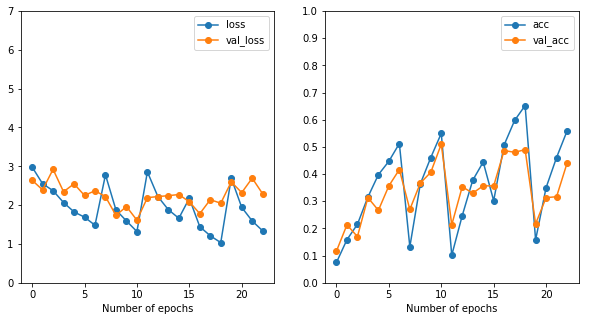

In [24]:
loss = np.empty(0)
val_loss = np.empty(0)
acc = np.empty(0)
val_acc = np.empty(0)

for history in histories:
    loss = np.append(loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
    acc = np.append(acc,history.history['triplet_acc'])
    val_acc = np.append(val_acc,history.history['val_triplet_acc'])

    
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.04.12.dogfacenet_v12.lfw.1.npy',history_)
np.savetxt(PATH_SAVE+'2018.04.12.dogfacenet_v12.lfw.1.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,8,1))
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,1.1,0.1))
plt.legend()

In [34]:
model.save(PATH_MODEL + '2019.04.12.dogfacenet_v12.lfw.'+str(0)+'.h5')

In [ ]:
# dogfacenet_v24
emb_size = 32

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=(104, 104, 3))

x = Conv2D(64, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

for layer in [64,64,128,256,512]:
    # Batch normalization layer
    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    r = BatchNormalization()(x)
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    r = Add()([r,x])
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    x = Add()([r,x])
    x = Dropout(0.25)(x)
    
    #model.add(Dropout(0.25))

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
#model.add(Dense(1024, activation='relu'))
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [ ]:
# dogfacenet_v23
emb_size = 32

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=(104, 104, 3))

x = Conv2D(64, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

for layer in [64,128,512,1024]:
    # Batch normalization layer
    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    r = BatchNormalization()(x)
    r = Dropout(0.25)(r)
    
    for i in range(2):
        gsize = layer//32
        branch = []
        for group in range(32):
            x = Conv2D(gsize, (1, 1), use_bias=False, padding='same')(r)
            x = BatchNormalization()(x)
            
            x = Conv2D(gsize, (3, 3), use_bias=False, activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Dropout(0.5)(x)
            
            branch += [x]
        
        x = Concatenate()(branch)
        x = Conv2D(layer, (1, 1), use_bias=False, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Add()([r,x])
        r = Dropout(0.25)(x)
    

x = GlobalAveragePooling2D()(r)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [ ]:
# dogfacenet_v18
emb_size = 32

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=(104, 104, 3))

x = Conv2D(32, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

for layer in [32,32,64,128,512]:
    
    for channel in range(4):
    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    r = BatchNormalization()(x)
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    r = Add()([r,x])
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    x = Add()([r,x])
    x = Dropout(0.25)(x)
    
    #model.add(Dropout(0.25))

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
#model.add(Dense(1024, activation='relu'))
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [ ]:
# dogfacenet_v20
# close to official resnet with identity blocks
emb_size = 32

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=(104, 104, 3))

x = Conv2D(16, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

layers = [16,32,64,128,512,1024]

for i in range(len(layers)-1):
    layer = layers[i]
    layer2 = layers[i+1]
    
    x = Conv2D(layer2, (3, 3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    r = Activation('relu')(x)
    
    # Resnet blocks
    for j in range(2):
        x = Conv2D(layer, (1, 1), padding='same')(r)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(layer, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(layer2, (1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Add()([r,x])
        x = Activation('relu')(x)
        r = Dropout(0.25)(x)

x = GlobalAveragePooling2D()(r)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [ ]:
# dogfacenet_v21
# close to official resneXt with identity blocks
emb_size = 32

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=(104, 104, 3))

x = Conv2D(32, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

layers = [32,64,128,512,1024,2048]

for i in range(len(layers)-1):
    layer = layers[i]
    layer2 = layers[i+1]
    
    x = Conv2D(layer2, (3, 3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    r = Activation('relu')(x)
    
    # ResneXt blocks, group 16
    for j in range(2):
        ksize = layer//16
        branch_res = []
        
        for k in range(16):
            x = Conv2D(ksize, (1, 1), padding='same')(r)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(ksize, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Dropout(0.5)(x)
            
            branch_res += [x]
        
        x = Concatenate()(branch_res)
        x = Conv2D(layer2, (1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Add()([r,x])
        x = Activation('relu')(x)
        r = Dropout(0.25)(x)

x = GlobalAveragePooling2D()(r)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [ ]:
model = tf.keras.models.load_model(PATH_MODEL + '2019.02.28.dogfacenet_v12.hard_triplet.alpha.0.3.2.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [ ]:
model = tf.keras.models.load_model(PATH_MODEL + '2019.02.14.dogfacenet_v11.hard_triplet_trained.data_aug.20.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [ ]:
model = tf.keras.models.load_model(PATH_MODEL + '2019.02.27.dogfacenet_v11.hard_triplet_trained.data_aug_2.16.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [ ]:
model.evaluate(triplet_test,y_triplet_test, batch_size=63)

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink(PATH_MODEL + '2019.02.28.dogfacenet_v12.hard_triplet.alpha.0.3.2.h5')

In [ ]:
FileLink(PATH_MODEL + '2019.02.28.dogfacenet_v12.hard_triplet.alpha.0.50.h5')

In [ ]:
FileLink(PATH_SAVE + '2018.02.27.dogfacenet_v11.hard_triplet.data_aug.10.a_0.3.npy')

In [ ]:
model.save(PATH_MODEL + '2019.02.12.hard_triplet_trained.data_aug.0.h5')

In [ ]:
triplet_train, y_triplet_train = define_triplets(images_train,labels_train)
triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)

In [ ]:
print(str((3*len(predict_train)+3*(nbof_classes//10 + 1),h,w,c)))

In [ ]:
del new_images_train
del new_labels_train
del predict_train
del triplet_train, y_triplet_train
gc.collect()

In [ ]:
new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
predict_train=model.predict(new_images_train)
triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train,10,3)

In [ ]:
histories = []

In [ ]:
for i in range(6):
    history = model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 21*3,
        epochs = 1,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )
    histories += [history]

In [ ]:
model.save(PATH_MODEL + '2019.04.08.dogfacenet_v12.'+str(1)+'.h5')

In [ ]:
histories2 = [histories[i] for i in range(29)]

In [ ]:
model = tf.keras.models.load_model(PATH_MODEL + '2019.02.27.dogfacenet_v11.hard_triplet_trained.data_aug.6.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [ ]:
for i in range(2):
    history = model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 21*3,
        epochs = 1,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )
    histories2 += [history]
model.save(PATH_MODEL + '2019.02.27.dogfacenet_v11.hard_triplet_trained.data_aug.'+str(16)+'.h5')

In [ ]:
histories = histories[:-2]

In [ ]:
model.compile(loss=triplet,
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=[triplet_acc])

- 14*3 epochs with lr=0.001
- 4*3 epochs with lr=0.0005
- 4*3 epochs with lr=0.0003
- 4*1 epochs with lr=0.0001

In [ ]:
 model.save(PATH_MODEL + '2019.02.28.dogfacenet_v22.hard_triplet.alpha.0.3.'+str(l)+'.h5')

In [ ]:
histories = []

In [ ]:
epochs = [14,4,4,4]
lr = [0.001,0.0005,0.0003,0.0001]
for l in range(1,len(lr)):
    model.compile(loss=triplet,
              optimizer=tf.keras.optimizers.Adam(lr[l]),
              metrics=[triplet_acc])
    for k in range(epochs[l]):
        epoch_nb = k+sum(epochs[:l])
        print("Beginning epoch number: "+str(epoch_nb)+", over "+str(sum(epochs))+" epochs. \n")

        
        new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
        predict_train=model.predict(new_images_train)
        triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train,10,3)

        for i in range(6):
            history = model.fit(
                triplet_train,
                y_triplet_train,
                batch_size = 21*3,
                epochs = 1,
                validation_data=(triplet_test,y_triplet_test),
                shuffle=False
            )
            histories += [history]
        
        del new_images_train, new_labels_train, predict_train, triplet_train, y_triplet_train
        gc.collect()
        model.save(PATH_MODEL + '2019.04.08.dogfacenet_v12.'+str(k)+'.h5')

        loss = np.empty(0)
        val_loss = np.empty(0)
        acc = np.empty(0)
        val_acc = np.empty(0)

        for history in histories:
            loss = np.append(loss,history.history['loss'])
            val_loss = np.append(val_loss,history.history['val_loss'])
            acc = np.append(acc,history.history['triplet_acc'])
            val_acc = np.append(val_acc,history.history['val_triplet_acc'])


        history_ = np.array([loss,val_loss,acc,val_acc])
        np.save(PATH_SAVE+'2019.04.08.dogfacenet_v12.npy',history_)
        np.savetxt(PATH_SAVE+'2019.04.08.dogfacenet_v12.txt',history_)

In [ ]:
model.save(PATH_MODEL + '2019.02.28.dogfacenet_v24.hard_triplet.alpha.0.3.'+str(0)+'.h5')

In [ ]:
history_ = np.load(PATH_SAVE+'2018.02.28.dogfacenet_v12.hard_triplet.data_aug.5.a_0.3.npy')

In [ ]:
loss,val_loss,acc,val_acc = history_

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val loss")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,8,1))
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val acc")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.legend()

In [ ]:

loss = np.empty(0)
val_loss = np.empty(0)
acc = np.empty(0)
val_acc = np.empty(0)

for history in histories:
    loss = np.append(loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
    acc = np.append(acc,history.history['triplet_acc'])
    val_acc = np.append(val_acc,history.history['val_triplet_acc'])

    
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.02.28.dogfacenet_v24.hard_triplet.data_aug.0.a_0.3.npy',history_)
np.savetxt(PATH_SAVE+'2018.02.28.dogfacenet_v24.hard_triplet.data_aug.0.a_0.3.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,8,1))
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,1.1,0.1))
plt.legend()

In [ ]:
for i in range(5):
    new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
    predict_train=model.predict(new_images_train)
    triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

    model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 21*3,
        epochs = 1,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )

    model.save(PATH_MODEL + '2019.02.14.dogfacenet_v11.hard_triplet_trained.data_aug.'+str(i+16)+'.h5')

In [ ]:
new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
predict_train=model.predict(new_images_train)
triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

In [ ]:
history=model.fit(
    triplet_train,
    y_triplet_train,
    batch_size = 21*3,
    epochs = 1,
    validation_data=(triplet_test,y_triplet_test),
    shuffle=False
)

In [ ]:
model.save(PATH_MODEL + '2019.02.14.dogfacenet_v11.hard_triplet_trained.data_aug.6.h5')

In [ ]:
loss = np.empty(0)
val_loss = np.empty(0)
acc = np.empty(0)
val_acc = np.empty(0)

loss = np.append(loss,history.history['loss'])
val_loss = np.append(val_loss,history.history['val_loss'])
acc = np.append(acc,history.history['triplet_acc'])
val_acc = np.append(val_acc,history.history['val_triplet_acc'])
    
    
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.02.12.dogfacenet_v6.hard_triplet.data_aug.0.a_0.3.npy',history_)
np.savetxt(PATH_SAVE+'2018.02.12.dogfacenet_v6.hard_triplet.data_aug.0.a_0.3.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.legend()

In [ ]:
histories = []
nbof_cycles = 9
for i in range(0,nbof_cycles,1):

    history=model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 21*3,
        epochs = nbof_cycles-i,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )
    
    histories += [history]
    model.save(PATH_MODEL + '2019.02.14.dogfacenet_v10.hard_triplet_trained.data_aug.' + str(i+1) + '.h5')
    
    new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
    predict_train=model.predict(new_images_train)
    triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

In [ ]:
loss = np.empty(0)
val_loss = np.empty(0)
acc = np.empty(0)
val_acc = np.empty(0)

for i in range(len(histories)):
    history = histories[i]
    
    loss = np.append(loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
    acc = np.append(acc,history.history['triplet_acc'])
    val_acc = np.append(val_acc,history.history['val_triplet_acc'])
    
    
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.02.13.dogfacenet_v9.hard_triplet.2.a_0.3.npy',history_)
np.savetxt(PATH_SAVE+'2018.02.13.dogfacenet_v9.hard_triplet.2.a_0.3.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.legend()

In [ ]:
# Test on new triplet integrity
print(new_y_triplet_train[-30:])
t = np.equal(new_y_triplet_train[0::3],new_y_triplet_train[1::3])
print(t)
np.sum(t.astype(np.float32))/len(t)

### Evaluate it

#### Evaluate on verification task

In [ ]:
NBOF_PAIRS = 5000
#NBOF_PAIRS = len(images_test)

# Create pairs
h,w,c = SIZE
pairs = np.empty((NBOF_PAIRS*2,h,w,c))
issame = np.empty(NBOF_PAIRS)
class_test = np.unique(labels_test)
for i in range(NBOF_PAIRS):
    alea = np.random.rand()
    # Pair of different dogs
    if alea < 0.5:
        # Chose the classes:
        class1 = np.random.randint(len(class_test))
        class2 = np.random.randint(len(class_test))
        while class1==class2:
            class2 = np.random.randint(len(class_test))
            
        # Extract images of this class:
        images_class1 = images_test[np.equal(labels_test,class1)]
        images_class2 = images_test[np.equal(labels_test,class2)]
        
        # Chose an image amoung these selected images
        pairs[i*2] = images_class1[np.random.randint(len(images_class1))]
        pairs[i*2+1] = images_class2[np.random.randint(len(images_class2))]
        issame[i] = 0
    # Pair of same dogs
    else:
        # Chose a class
        clas = np.random.randint(len(class_test))
        images_class = images_test[np.equal(labels_test,clas)]
        
        # Select two images from this class
        idx_image1 = np.random.randint(len(images_class))
        idx_image2 = np.random.randint(len(images_class))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(images_class))
        
        pairs[i*2] = images_class[idx_image1]
        pairs[i*2+1] = images_class[idx_image2]
        issame[i] = 1

In [ ]:
# Test: Check the pairs
s = 10
n = 5
print(issame[s:(n+s)])
fig = plt.figure(figsize=(5,3*n))
for i in range(s,s+n):
    plt.subplot(n,2,2*(i-s)+1)
    plt.imshow(pairs[2*i]*0.5+0.5)
    plt.subplot(n,2,2*(i-s)+2)
    plt.imshow(pairs[2*i+1]*0.5+0.5)

In [ ]:
predict=model.predict(pairs)
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
diff = np.square(emb1-emb2)
dist = np.sum(diff,1)


best = 0
best_t = 0
thresholds = np.arange(0.001,4,0.001)
for i in tqdm_notebook(range(len(thresholds))):
    less = np.less(dist, thresholds[i])
    acc = np.logical_not(np.logical_xor(less, issame))
    acc = acc.astype(float)
    out = np.sum(acc)
    out = out/len(acc)
    if out > best:
        best_t = thresholds[i]
        best = out

print("Best threshold: " + str(best_t))
print("Best accuracy: " + str(best))

In [ ]:
# False accepted examples and False rejected examples
t = 0.68
fa = []
fr = []
for i in range(len(dist)):
    # false accepted
    if issame[i] == 0 and dist[i]<t:
        fa += [i]
    if issame[i] == 1 and dist[i]>t:
        fr += [i]

In [ ]:
# Test: Look at wrong pairs
s = 10
sr = 20
n = 5
print(issame[s:(n+s)])
fig = plt.figure(figsize=(11,2.8*n))
for i in range(s,s+n):
    # False accepted
    plt.subplot(n,4,4*(i-s)+1)
    plt.imshow(pairs[2*fa[i+s]])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(n,4,4*(i-s)+2)
    plt.imshow(pairs[2*fa[i+s]+1])
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(n,4,4*(i-s)+3)
    plt.imshow(pairs[2*fr[i+sr]])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(n,4,4*(i-s)+4)
    plt.imshow(pairs[2*fr[i+sr]+1])
    plt.xticks([])
    plt.yticks([])

In [ ]:
len(fa)

In [ ]:
len(fr)

In [ ]:
threshold = 0.3
less = np.less(dist, threshold)
acc = np.logical_not(np.logical_xor(less, issame))
acc = acc.astype(float)
out = np.sum(acc)
out = out/len(acc)

print("Accuracy: " + str(out))

### ROC curve

In [ ]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(pairs)
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
diff = np.square(emb1-emb2)
dist = np.sum(diff,1)

# Computes the ROC depending on different thresholds

thresholds = np.arange(0.001,4,0.001)
tprs = np.empty(len(thresholds))
fprs = np.empty(len(thresholds))

p = np.sum(issame.astype(float))
n = np.sum(np.logical_not(issame).astype(float))

for i in tqdm_notebook(range(len(thresholds))):
    logical_pred = np.less(dist, thresholds[i])
    tp = np.sum(np.logical_and(logical_pred,issame).astype(float))
    fp = np.sum(np.logical_and(logical_pred,np.logical_not(issame)).astype(float))
    tprs[i] = tp/p
    fprs[i] = fp/n
    

In [ ]:
np.save('roc_dogfacenet_v11.npy', [tprs, fprs])

In [ ]:
tprs2,fprs2 = np.load('roc_dogfacenet_v12.npy')

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(fprs,tprs,label="VGG-like")
plt.plot(fprs2,tprs2,label="ResNet-like")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.legend()
#plt.title("ROC curve")

### Second verification task: IN or OUT? actually I think that this task doesn't make any sense

In [ ]:
pred_test = model.predict(images_test)

In [ ]:
nbof_try = 30 # We will do many try on the test dataset to obtain a more precize accuracy

for propo in [0.5,0.6,0.7,0.8,0.9]:
    print("Current propotion of classes considered: " + str(propo))
    
    mean_acc = 0
    max_acc = 0
    min_acc = 1
    mean_t = 0
    
    for _ in tqdm_notebook(range(nbof_try)):
        nbof_kimages=int(propo*len(np.unique(labels_test)))
        kpred=np.empty((nbof_kimages,pred_test.shape[-1]))
        y_kimages = np.unique(labels_test)[:nbof_kimages]

        others_pred = np.copy(pred_test)
        y_others = np.copy(labels_test)

        for i in range(nbof_kimages):
            keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
            choice = np.random.randint(len(keep_classes_images))

            kpred[i] = others_pred[keep_classes_images[choice]]

            others_pred = np.delete(others_pred,keep_classes_images[choice],0)
            y_others = np.delete(y_others,keep_classes_images[choice],0)

        # We find the best threshold for this dataset
        best_acc = 0
        best_t = 0.01
        for threshold in np.arange(0.01,1,0.01):

            acc = 0

            class_pred = np.empty(len(others_pred))

            for i in range(len(others_pred)):
                # computes distance with the key dataset
                dist = np.sum(np.square(kpred-others_pred[i]),1)
                if np.min(dist) < threshold:
                    if y_others[i] in y_kimages:
                        acc += 1
                else:
                    if not y_others[i] in y_kimages:
                        acc += 1
            acc /= len(others_pred)

            if acc > best_acc:
                best_acc = acc
                best_t = threshold

        mean_acc += best_acc
        mean_t += best_t
        
        if best_acc > max_acc:
            max_acc = best_acc
        if best_acc < min_acc:
            min_acc = best_acc
        
    mean_acc /= nbof_try
    
    mean_t /= nbof_try
    print("Mean accuracy for in/out: " + str(mean_acc))
    print("Max accuracy for in/out: " + str(max_acc))
    print("Min accuracy for in/out: " + str(min_acc))
    print("Mean threshold for in/out: " + str(mean_t))

### Face clustering

In [ ]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(images_test)

In [ ]:
predict=model.predict(images_test)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=len(np.unique(labels_test)),max_iter=2000, random_state=0,tol=0.2).fit(predict)

In [ ]:
images_cluster = [images_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]
labels_cluster = [labels_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]

In [ ]:
len(images_train)

In [ ]:
len(images_test)

In [ ]:
i = 10
length = len(images_cluster[i])
fig=plt.figure(figsize=(5,5))
for j in range(3):
    for k in range(3):
        plt.subplot(3,3,j*3+k+1)
        plt.imshow(images_cluster[i][j*3+k])
        plt.xticks([])
        plt.yticks([])
#fig.savefig('D:/CREATIONS/PAPERS/DogFaceNet/clustering/dfn12.clustering.1000.png')

In [ ]:
for i in range(len(images_cluster)):
    length = len(images_cluster[i])
    if length > 0:
        print(labels_cluster[i])
        fig=plt.figure(figsize=(length*2,2))
        for j in range(length):
            plt.subplot(1,length,j+1)
            plt.imshow(images_cluster[i][j])
            plt.xticks([])
            plt.yticks([])
        plt.show()
        #fig.savefig('D:/CREATIONS/PAPERS/DogFaceNet/clustering/dfn12.clustering.'+str(i)+'.png')

### Recognition: K-NN
m is the number of images that are going to be selected for k-NN "training".

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
count_im_c = np.zeros(len(np.unique(labels_test)))
for i in range(len(labels_test)):
    count_im_c[int(labels_test[i])] += 1
print("Number of images per classes:")
count_im_c

In [ ]:
for m in range(1,5):
    
    # First we drop the classes with less than m images per class:
    to_drop = []
    for i in range(len(count_im_c)):
        if count_im_c[i] <= m:
            to_drop += [i]
    new_labels_test = np.copy(labels_test)
    new_images_test = np.copy(images_test)
    for i in range(len(to_drop)):
        idx_to_drop = np.arange(len(new_labels_test))[np.equal(to_drop[i],new_labels_test)]
        new_labels_test=np.delete(new_labels_test, idx_to_drop, 0)
        new_images_test=np.delete(new_images_test, idx_to_drop, 0)
    np.unique(new_labels_test)
    
    # Model prediction on the reduce dataset
    new_pred_test = model.predict(new_images_test)

    nbof_test = 1000
    mean_acc = 0
    mini = 1
    maxi = 0
    
    # Definition of K
    if m == 1:
        K = 1
    else:
        K = m+1

    for _ in tqdm_notebook(range(nbof_test)):
        # I select m images per classes for k-NN training
        nbof_kimages=m*len(np.unique(new_labels_test))
        kpred=np.empty((nbof_kimages,new_pred_test.shape[-1]))
        y_kimages = np.empty(nbof_kimages, dtype=int)
        y_kuniques = np.unique(new_labels_test)
        for i in range(len(y_kuniques)):
            for j in range(m):
                y_kimages[i*m+j] = y_kuniques[i]

        others_pred = np.copy(new_pred_test)
        y_others = np.copy(new_labels_test)

        for i in range(len(y_kuniques)):
            keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i*m],y_others)]
            choices = np.empty(0,dtype=int)

            if len(keep_classes_images) <= m:
                print("Bug!")
                break

            for j in range(m):
                choice = np.random.randint(len(keep_classes_images))
                while choice in choices:
                    choice = np.random.randint(len(keep_classes_images))
                choices=np.append(choices,choice)
            #print(choices)
            for j in range(m):
                kpred[i*m+j] = others_pred[keep_classes_images[choices[j]]]

            others_pred = np.delete(others_pred,keep_classes_images[choices],0)
            y_others = np.delete(y_others,keep_classes_images[choices],0)

        neigh = KNeighborsClassifier(n_neighbors=K, weights='distance')
        neigh.fit(kpred, y_kimages)
        acc = np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)

        if mini > acc:
            mini = acc
        if maxi < acc:
            maxi = acc

        mean_acc += acc
    mean_acc /= nbof_test
    print("Mean accuracy: " + str(mean_acc))
    print("Maximum accuracy: " + str(maxi))
    print("Minimum accuracy: " + str(mini))

In [ ]:
nbof_test = 1000
mean_acc = 0
mini = 1
maxi = 0
if m == 1:
    K = 1
else:
    K = m+1

for _ in tqdm_notebook(range(nbof_test)):
    # Second we select m images per classes for k-NN training
    nbof_kimages=m*len(np.unique(new_labels_test))
    kpred=np.empty((nbof_kimages,new_pred_test.shape[-1]))
    y_kimages = np.empty(nbof_kimages, dtype=int)
    y_kuniques = np.unique(new_labels_test)
    for i in range(len(y_kuniques)):
        for j in range(m):
            y_kimages[i*m+j] = y_kuniques[i]

    others_pred = np.copy(new_pred_test)
    y_others = np.copy(new_labels_test)

    for i in range(len(y_kuniques)):
        keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i*m],y_others)]
        choices = np.empty(0,dtype=int)

        if len(keep_classes_images) <= m:
            print("Bug!")
            break

        for j in range(m):
            choice = np.random.randint(len(keep_classes_images))
            while choice in choices:
                choice = np.random.randint(len(keep_classes_images))
            choices=np.append(choices,choice)
        #print(choices)
        for j in range(m):
            kpred[i*m+j] = others_pred[keep_classes_images[choices[j]]]

        others_pred = np.delete(others_pred,keep_classes_images[choices],0)
        y_others = np.delete(y_others,keep_classes_images[choices],0)

    neigh = KNeighborsClassifier(n_neighbors=K, weights='distance')
    neigh.fit(kpred, y_kimages)
    acc = np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)
    
    if mini > acc:
        mini = acc
    if maxi < acc:
        maxi = acc
    
    mean_acc += acc
mean_acc /= nbof_test
print("Mean accuracy: " + str(mean_acc))
print("Maximum accuracy: " + str(maxi))
print("Minimum accuracy: " + str(mini))

### Recognition: k-NN top 1/2/3/4/5

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
count_im_c = np.zeros(len(np.unique(labels_test)))
for i in range(len(labels_test)):
    count_im_c[int(labels_test[i])] += 1
print("Number of images per classes:")
count_im_c

In [ ]:
max_rk = 5 # Top "max_rk" accuracy

for m in range(1,5):
    # First we drop the classes with less than m images per class:
    to_drop = []
    for i in range(len(count_im_c)):
        if count_im_c[i] <= m:
            to_drop += [i]
    new_labels_test = np.copy(labels_test)
    new_images_test = np.copy(images_test)
    for i in range(len(to_drop)):
        idx_to_drop = np.arange(len(new_labels_test))[np.equal(to_drop[i],new_labels_test)]
        new_labels_test=np.delete(new_labels_test, idx_to_drop, 0)
        new_images_test=np.delete(new_images_test, idx_to_drop, 0)
    np.unique(new_labels_test)

    new_pred_test = model.predict(new_images_test)

    nbof_test = 100
    mean_acc = 0
    mini = 1
    maxi = 0

    if m == 1:
        K = 1
    else:
        K = m+1

    for _ in tqdm_notebook(range(nbof_test)):
        # Second we select m images per classes for k-NN training
        nbof_kimages=m*len(np.unique(new_labels_test))
        kpred=np.empty((nbof_kimages,new_pred_test.shape[-1]))
        y_kimages = np.empty(nbof_kimages, dtype=int)
        y_kuniques = np.unique(new_labels_test)
        for i in range(len(y_kuniques)):
            for j in range(m):
                y_kimages[i*m+j] = y_kuniques[i]

        others_pred = np.copy(new_pred_test)
        y_others = np.copy(new_labels_test)

        for i in range(len(y_kuniques)):
            keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i*m],y_others)]
            choices = np.empty(0,dtype=int)

            if len(keep_classes_images) <= m:
                print("Bug!")
                break

            for j in range(m):
                choice = np.random.randint(len(keep_classes_images))
                while choice in choices:
                    choice = np.random.randint(len(keep_classes_images))
                choices=np.append(choices,choice)
            #print(choices)
            for j in range(m):
                kpred[i*m+j] = others_pred[keep_classes_images[choices[j]]]

            others_pred = np.delete(others_pred,keep_classes_images[choices],0)
            y_others = np.delete(y_others,keep_classes_images[choices],0)

        neigh = KNeighborsClassifier(n_neighbors=K, weights='distance')
        neigh.fit(kpred, y_kimages)

        rk1_pred_y_others = neigh.predict(others_pred)
        pred_y_others = np.zeros((len(others_pred),max_rk))
        for i in range(len(pred_y_others)):
            pred_y_others[i][0] = rk1_pred_y_others[i]

        for i in range(1,max_rk):
            for j in range(len(pred_y_others)):
                previous_pred = [pred_y_others[j][k] for k in range(0,i)]
                to_keep = np.logical_not(np.equal(previous_pred[0],y_kimages))
                for k in range(1,len(previous_pred)):
                    to_keep = np.logical_and(to_keep, np.logical_not(np.equal(previous_pred[k],y_kimages)))
                new_kpred = kpred[to_keep]
                new_y_kimages = y_kimages[to_keep]

                neigh.fit(new_kpred, new_y_kimages)

                pred_y_others[j][i] = neigh.predict([others_pred[j]])

        #acc = np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)
        acc = 0
        for i in range(len(pred_y_others)):
            if y_others[i] in pred_y_others[i]:
                acc += 1
        acc /= len(pred_y_others)

        if mini > acc:
            mini = acc
        if maxi < acc:
            maxi = acc

        mean_acc += acc
    mean_acc /= nbof_test
    print("Mean accuracy: " + str(mean_acc))
    print("Maximum accuracy: " + str(maxi))
    print("Minimum accuracy: " + str(mini))

In [ ]:
m = 2
# First we drop the classes with less than m images per class:
to_drop = []
for i in range(len(count_im_c)):
    if count_im_c[i] <= m:
        to_drop += [i]
new_labels_test = np.copy(labels_test)
new_images_test = np.copy(images_test)
for i in range(len(to_drop)):
    idx_to_drop = np.arange(len(new_labels_test))[np.equal(to_drop[i],new_labels_test)]
    new_labels_test=np.delete(new_labels_test, idx_to_drop, 0)
    new_images_test=np.delete(new_images_test, idx_to_drop, 0)
np.unique(new_labels_test)

new_pred_test = model.predict(new_images_test)

In [ ]:
nbof_test = 100
mean_acc = 0
mini = 1
maxi = 0
max_rk = 5

if m == 1:
    K = 1
else:
    K = m+1

for _ in tqdm_notebook(range(nbof_test)):
    # Second we select m images per classes for k-NN training
    nbof_kimages=m*len(np.unique(new_labels_test))
    kpred=np.empty((nbof_kimages,new_pred_test.shape[-1]))
    y_kimages = np.empty(nbof_kimages, dtype=int)
    y_kuniques = np.unique(new_labels_test)
    for i in range(len(y_kuniques)):
        for j in range(m):
            y_kimages[i*m+j] = y_kuniques[i]

    others_pred = np.copy(new_pred_test)
    y_others = np.copy(new_labels_test)

    for i in range(len(y_kuniques)):
        keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i*m],y_others)]
        choices = np.empty(0,dtype=int)

        if len(keep_classes_images) <= m:
            print("Bug!")
            break

        for j in range(m):
            choice = np.random.randint(len(keep_classes_images))
            while choice in choices:
                choice = np.random.randint(len(keep_classes_images))
            choices=np.append(choices,choice)
        #print(choices)
        for j in range(m):
            kpred[i*m+j] = others_pred[keep_classes_images[choices[j]]]

        others_pred = np.delete(others_pred,keep_classes_images[choices],0)
        y_others = np.delete(y_others,keep_classes_images[choices],0)

    neigh = KNeighborsClassifier(n_neighbors=K, weights='distance')
    neigh.fit(kpred, y_kimages)
    
    rk1_pred_y_others = neigh.predict(others_pred)
    pred_y_others = np.zeros((len(others_pred),max_rk))
    for i in range(len(pred_y_others)):
        pred_y_others[i][0] = rk1_pred_y_others[i]

    for i in range(1,max_rk):
        for j in range(len(pred_y_others)):
            previous_pred = [pred_y_others[j][k] for k in range(0,i)]
            to_keep = np.logical_not(np.equal(previous_pred[0],y_kimages))
            for k in range(1,len(previous_pred)):
                to_keep = np.logical_and(to_keep, np.logical_not(np.equal(previous_pred[k],y_kimages)))
            new_kpred = kpred[to_keep]
            new_y_kimages = y_kimages[to_keep]
            
            neigh.fit(new_kpred, new_y_kimages)
    
            pred_y_others[j][i] = neigh.predict([others_pred[j]])

    #acc = np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)
    acc = 0
    for i in range(len(pred_y_others)):
        if y_others[i] in pred_y_others[i]:
            acc += 1
    acc /= len(pred_y_others)
    
    if mini > acc:
        mini = acc
    if maxi < acc:
        maxi = acc
    
    mean_acc += acc
mean_acc /= nbof_test
print("Mean accuracy: " + str(mean_acc))
print("Maximum accuracy: " + str(maxi))
print("Minimum accuracy: " + str(mini))

#### k-NN test part

In [ ]:
m = 3
# First we drop the classes with less than m images per class:
to_drop = []
for i in range(len(count_im_c)):
    if count_im_c[i] <= m:
        to_drop += [i]
new_labels_test = np.copy(labels_test)
new_images_test = np.copy(images_test)
for i in range(len(to_drop)):
    idx_to_drop = np.arange(len(new_labels_test))[np.equal(to_drop[i],new_labels_test)]
    new_labels_test=np.delete(new_labels_test, idx_to_drop, 0)
    new_images_test=np.delete(new_images_test, idx_to_drop, 0)
np.unique(new_labels_test)

In [ ]:
new_pred_test = model.predict(new_images_test)

In [ ]:
# Second we select m images per classes for k-NN training
nbof_kimages=m*len(np.unique(new_labels_test))
kpred=np.empty((nbof_kimages,new_pred_test.shape[-1]))
y_kimages = np.empty(nbof_kimages, dtype=int)
y_kuniques = np.unique(new_labels_test)
for i in range(len(y_kuniques)):
    for j in range(m):
        y_kimages[i*2+j] = y_kuniques[i]

others_pred = np.copy(new_pred_test)
y_others = np.copy(new_labels_test)

for i in range(len(y_kuniques)):
    keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i*2],y_others)]
    choices = np.empty(0,dtype=int)
    
    if len(keep_classes_images) <= m:
        print("Bug!")
        break
        
    for j in range(m):
        choice = np.random.randint(len(keep_classes_images))
        while choice in choices:
            choice = np.random.randint(len(keep_classes_images))
        choices=np.append(choices,choice)
    #print(choices)
    for j in range(m):
        kpred[i*2+j] = others_pred[keep_classes_images[choices[j]]]

    others_pred = np.delete(others_pred,keep_classes_images[choices],0)
    y_others = np.delete(y_others,keep_classes_images[choices],0)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=m+1, weights='distance')
neigh.fit(kpred, y_kimages)
np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)

In [ ]:
n = 1000
mean_acc = 0

for j in tqdm_notebook(range(n)):
    nbof_kimages=len(np.unique(new_labels_test))
    kpred=np.empty((nbof_kimages,new_pred_test.shape[-1]))
    y_kimages = np.unique(new_labels_test)[:nbof_kimages]

    others_pred = np.copy(new_pred_test)
    y_others = np.copy(new_labels_test)

    for i in range(nbof_kimages):
        keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
        choice = np.random.randint(len(keep_classes_images))

        kpred[i] = others_pred[keep_classes_images[choice]]

        others_pred = np.delete(others_pred,keep_classes_images[choice],0)
        y_others = np.delete(y_others,keep_classes_images[choice],0)

    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(kpred, y_kimages) 

    mean_acc += np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)
    
mean_acc /= n
mean_acc

In [ ]:
n = 1000
mean_acc = 0

for j in tqdm_notebook(range(n)):
    nbof_kimages=len(np.unique(labels_test))
    kpred=np.empty((nbof_kimages,pred_test.shape[-1]))
    y_kimages = np.unique(labels_test)[:nbof_kimages]

    others_pred = np.copy(pred_test)
    y_others = np.copy(labels_test)

    for i in range(nbof_kimages):
        keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
        choice = np.random.randint(len(keep_classes_images))

        kpred[i] = others_pred[keep_classes_images[choice]]

        others_pred = np.delete(others_pred,keep_classes_images[choice],0)
        y_others = np.delete(y_others,keep_classes_images[choice],0)

    neigh.fit(kpred, y_kimages) 

    mean_acc += np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)
    
mean_acc /= n
mean_acc

In [ ]:
nbof_kimages=len(np.unique(new_labels_test))
kpred=np.empty((nbof_kimages,new_pred_test.shape[-1]))
y_kimages = np.unique(new_labels_test)[:nbof_kimages]

others_pred = np.copy(new_pred_test)
y_others = np.copy(new_labels_test)

for i in range(nbof_kimages):
    keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
    choice = np.random.randint(len(keep_classes_images))
    
    kpred[i] = others_pred[keep_classes_images[choice]]
    
    others_pred = np.delete(others_pred,keep_classes_images[choice],0)
    y_others = np.delete(y_others,keep_classes_images[choice],0)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(kpred, y_kimages) 

In [ ]:
np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)

In [ ]:
mean_acc = 0
nbof_try = 1 # We will do many try on the test dataset to obtain a more precize accuracy

for k in tqdm_notebook(range(nbof_try)):
    nbof_kimages=int(1.0*len(np.unique(labels_test)))
    kpred=np.empty((nbof_kimages,pred_test.shape[-1]))
    y_kimages = np.unique(labels_test)[:nbof_kimages]

    others_pred = np.copy(pred_test)
    y_others = np.copy(labels_test)

    for i in range(nbof_kimages):
        keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
        choice = np.random.randint(len(keep_classes_images))

        kpred[i] = others_pred[keep_classes_images[choice]]

        others_pred = np.delete(others_pred,keep_classes_images[choice],0)
        y_others = np.delete(y_others,keep_classes_images[choice],0)
    
    threshold = 0.6

    acc = 0

    class_pred = np.empty(len(others_pred))

    for i in range(len(others_pred)):
        # computes distance with the key dataset
        dist = np.sum(np.square(kpred-others_pred[i]),1)
        if np.min(dist) < threshold:
            class_pred[i] = y_others[i]
#             if y_others[i] in y_kimages:
#                 acc += 1
            if np.argmin(dist)==y_others[i]:
                acc += 1
        else:
            class_pred[i] = -1
            if not y_others[i] in y_kimages:
                acc += 1

    acc /= len(others_pred)
    
    mean_acc += acc
    
mean_acc /= nbof_try
print("Mean accuracy for a one shot learner: " + str(mean_acc))

In [ ]:
def find_n_mins(t,n):
    idx_mins = []
    mins = []
    for i in range(n):
        idx_crt_min = 0
        crt_min = t[0]
        for j in range(1,len(t)):
            if t[j] < crt_min:
                crt_min = t[j]
                idx_crt_min = j
        idx_mins += [idx_crt_min]
        mins += [crt_min]
        t = t[:idx_crt_min] + t[idx_crt_min+1:]
    return idx_mins, mins

### Recognition: One-shot learning (deprecated: use the above part with M=1 instead)

In [ ]:
pred_test = model.predict(images_test)

In [ ]:
mean_acc = 0
nbof_try = 1000 # We will do many try on the test dataset to obtain a more precize accuracy

for k in tqdm_notebook(range(nbof_try)):
    nbof_kimages=int(1.0*len(np.unique(labels_test)))
    kpred=np.empty((nbof_kimages,pred_test.shape[-1]))
    y_kimages = np.unique(labels_test)[:nbof_kimages]

    others_pred = np.copy(pred_test)
    y_others = np.copy(labels_test)

    for i in range(nbof_kimages):
        keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
        choice = np.random.randint(len(keep_classes_images))

        kpred[i] = others_pred[keep_classes_images[choice]]

        others_pred = np.delete(others_pred,keep_classes_images[choice],0)
        y_others = np.delete(y_others,keep_classes_images[choice],0)
    
    threshold = 0.6

    acc = 0

    class_pred = np.empty(len(others_pred))

    for i in range(len(others_pred)):
        # computes distance with the key dataset
        dist = np.sum(np.square(kpred-others_pred[i]),1)
        if np.min(dist) < threshold:
            class_pred[i] = 1
#             if y_others[i] in y_kimages:
#                 acc += 1
            if np.argmin(dist)==y_others[i]:
                acc += 1
        else:
            class_pred[i] = -1
            if not y_others[i] in y_kimages:
                acc += 1

    acc /= len(others_pred)
    
    mean_acc += acc
    
mean_acc /= nbof_try
print("Mean accuracy for a one shot learner: " + str(mean_acc))

#### Test for one-shot learning:

In [ ]:
# To train a one-shot learner on the test dataset:
#  -we randomly select key images: one picture per classes among 80% of the classes
#  -we take a new picture
#  -we check if the dog if the dog is known or not:
#   computes the distance between the embedding vector and every embeddings saved in
#   the dataset and compares the given distance with a threshold
#  -if not, return -1
#  -if yes, return the corresponding class

# Note: for the test we could have compute the prediction for every pictures and
# then separate key frames from the others but we played RP here :)




# We randomly select key images: one picture per classes among 80% of the classes
nbof_kimages=int(0.8*len(np.unique(labels_test)))
kimages=np.empty((nbof_kimages,h,w,c))
y_kimages = np.unique(labels_test)[:nbof_kimages]

others = np.copy(images_test)
y_others = np.copy(labels_test)

for i in range(nbof_kimages):
    keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
    choice = np.random.randint(len(keep_classes_images))
    
    kimages[i] = others[keep_classes_images[choice]]
    
    others = np.delete(others,keep_classes_images[choice],0)
    y_others = np.delete(y_others,keep_classes_images[choice],0)

kpred = model.predict(kimages)

# Prediction for every other pictures
others_pred = model.predict(others)

In [ ]:
pred_test = model.predict(images_test)

In [ ]:
# To train a one-shot learner on the test dataset:
#  -we randomly select key images: one picture per classes among 80% of the classes
#  -we take a new picture
#  -we check if the dog if the dog is known or not:
#   computes the distance between the embedding vector and every embeddings saved in
#   the dataset and compares the given distance with a threshold
#  -if not, return -1
#  -if yes, return the corresponding class

# Note: for the test we could have compute the prediction for every pictures and
# then separate key frames from the others but we played RP here :)




# We randomly select key images: one picture per classes among 80% of the classes
nbof_kimages=int(0.8*len(np.unique(labels_test)))
kpred=np.empty((nbof_kimages,pred_test.shape[-1]))
y_kimages = np.unique(labels_test)[:nbof_kimages]

others_pred = np.copy(pred_test)
y_others = np.copy(labels_test)

for i in range(nbof_kimages):
    keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
    choice = np.random.randint(len(keep_classes_images))
    
    kpred[i] = others_pred[keep_classes_images[choice]]
    
    others_pred = np.delete(others_pred,keep_classes_images[choice],0)
    y_others = np.delete(y_others,keep_classes_images[choice],0)

In [ ]:
# we will use the best threshold find on verification task
threshold = 0.3

# for i in range(len(others_pred)):

acc = 0

class_pred = np.empty(len(others_pred))

for i in range(len(others_pred)):
    # computes distance with the key dataset
    dist = np.sum(np.square(kpred-others_pred[i]),1)
    if np.min(dist) < threshold:
        class_pred[i] = np.argmin(dist)
        if np.argmin(dist)==y_others[i]:
            acc += 1
    else:
        class_pred[i] = -1
        if not y_others[i] in y_kimages:
            acc += 1
        
acc /= len(others_pred)
acc

In [ ]:
# we will find the best threshold for verification
best_acc = 0
best_t = 0.001
for threshold in np.arange(0.001,1,0.001):

    acc = 0

    class_pred = np.empty(len(others_pred))

    for i in range(len(others_pred)):
        # computes distance with the key dataset
        dist = np.sum(np.square(kpred-others_pred[i]),1)
        if np.min(dist) < threshold:
            class_pred[i] = np.argmin(dist)
            if np.argmin(dist)==y_others[i]:
                acc += 1
#             if y_others[i] in y_kimages:
#                 acc += 1
        else:
            class_pred[i] = -1
            if not y_others[i] in y_kimages:
                acc += 1
    acc /= len(others_pred)
    
    if acc > best_acc:
        best_acc = acc
        best_t = threshold


print(best_acc)
print(best_t)

In [ ]:
plt.figure(figsize=(8,5))
for i in range(38):
    plt.subplot(5,8,i+1)
    plt.imshow(kimages[i])

In [ ]:
plt.figure(figsize=(13,18))
for i in range(13*18):
    plt.subplot(18,13,i+1)
    plt.imshow(others[i])

### Recognition: Re-training

In [ ]:
s = 30.
m = 0.3
def cosine(y_true,y_pred):
    
    exp_s = K.exp(s * y_pred)
    exp_s_m = K.exp(s * (y_pred - m))
    
    masked_exp_s_m = exp_s_m * y_true
    
    inv_mask = 1. - y_true
    masked_exp_s = exp_s * inv_mask
    
    den = K.sum(masked_exp_s + masked_exp_s_m, axis=-1, keepdims=True)
    out = masked_exp_s_m / den
    out = K.sum(out,axis=-1)
    ret = - K.log(out)
    ret = K.sum(ret)
    return ret

In [ ]:
class Cosine(tf.keras.layers.Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Cosine, self).__init__(**kwargs)

    def build(self, input_shape):
        shape = tf.TensorShape((input_shape[-1],self.output_dim))

        self.kernel = self.add_weight(name='kernel', 
                                      shape=shape,
                                      initializer='uniform',
                                      trainable=True)
        super(Cosine, self).build(input_shape)

    def call(self, x):
        x = tf.math.l2_normalize(x, axis=-1)
        w = tf.math.l2_normalize(self.kernel, axis=0)
        
        return K.dot(x, w)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [ ]:
labels_test_exp = tf.keras.utils.to_categorical(labels_test)

In [ ]:
#out = tf.keras.layers.Dense(128, activation='relu')(model.output)
out = Cosine(len(labels_test_exp[0]))(model.output)
#out = tf.keras.layers.Dense(24, activation='softmax')(out)
recog = tf.keras.Model(model.input,out)
for layer in model.layers: layer.trainable = False
recog.compile(tf.keras.optimizers.Adam(),loss=cosine,metrics=['accuracy'])

In [ ]:
recog.fit(images_test,labels_test_exp,batch_size=64,epochs=30)

### Observation on the heatmap

In [ ]:
model.layers

In [ ]:
mod3 = tf.keras.Model(model.layers[0].input, model.layers[9].output)
predict3 = mod3.predict(images_train[0:100:10])

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(10,10,i*10+1)
    sk.io.imshow(images_train[i*10])
    
    for j in range(9):
        pred3 = np.mean(predict3[i][:,:,j*25:j*25+3],axis=-1)
        plt.subplot(10,10,i*10+2+j)
        sk.io.imshow(images_train[i*10])
        plt.imshow(pred3,cmap='plasma')

In [ ]:
s = 100
mod1 = tf.keras.Model(model.layers[0].input, model.layers[1].output)
predict1 = mod1.predict(images_train[0+s:100+s:10])

mod2 = tf.keras.Model(model.layers[0].input, model.layers[9].output)
predict2 = mod2.predict(images_train[0+s:100+s:10])

mod3 = tf.keras.Model(model.layers[0].input, model.layers[14].output)
predict3 = mod3.predict(images_train[0+s:100+s:10])

plt.figure(figsize=(9,20))
for i in range(10):
    pred1 = np.mean(predict1[i],axis=-1)
    pred2 = np.mean(predict2[i],axis=-1)
    pred3 = np.mean(predict3[i],axis=-1)

    
    plt.subplot(10,4,i*4+1)
    sk.io.imshow(images_train[i*10 + s])
    plt.subplot(10,4,i*4+2)
    plt.imshow(pred1,cmap='plasma')
    plt.subplot(10,4,i*4+3)
    plt.imshow(pred2,cmap='plasma')
    plt.subplot(10,4,i*4+4)
    plt.imshow(pred3,cmap='plasma')

In [ ]:
history = model.fit_generator(
    train_datagen.flow(images_train,labels_train,batch_size = 64),
    epochs = 12,
    validation_data=(images_valid,labels_valid)
)

In [ ]:
model.save('../output/model/dogfacenet_v6_cosine.h5')